# The purpose of this notebook:

To transform the data as needed up until preproc pipeline

The comments below describe

In [1]:
# drop company_id
# drop payment_note_amount , payment_note_date until further notice
# create financials dates features: 
# - modal month
# - number of different months
# - year of financials_date 
# max year, min year, max gap between years (sometimes more than one in a year)

#drop the financials_dates
# include missing years as feature (derived from diff lag feature groups)

#zero fill features
#scale features

In [1]:
import pandas as pd
import numpy as np 

In [2]:
base_dir = #insert
data_dir = base_dir + 'Data/'
train_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')

In [3]:
train_inds = train_df.company_id
test_inds = test_df.company_id

In [4]:
credit_df = pd.concat([train_df,test_df],axis=0).set_index('company_id')

In [5]:
# drop cols 
credit_df = credit_df.drop(['payment_note_amount','payment_note_date'],axis=1)


In [6]:
# fillna lags

financial_cols=['financials_date','financials_date-1','financials_date-2','financials_date-3','financials_date-4']

fill_cols=[x for x in credit_df.columns if x not in financial_cols]
fill_cols.remove('Rating')
credit_df[fill_cols] = credit_df[fill_cols].fillna(0)

In [7]:
# create financial dates features

financials_df = credit_df[financial_cols]


In [8]:
# modal month
import statistics as st

for col in financial_cols:
    financials_df[col] = credit_df[col].apply(lambda row: str(row)[:3])
financials_df['modal_month'] = financials_df.apply(lambda row: st.mode(row),axis=1)
financials_df['modal_month'] = np.where(financials_df['modal_month']=='nan',financials_df[financial_cols[0]],financials_df['modal_month'])
credit_df['modal_month'] = financials_df['modal_month'] 


C:\Users\nikig\AppData\Local\Temp/ipykernel_8868/3025456064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials_df[col] = credit_df[col].apply(lambda row: str(row)[:3])
C:\Users\nikig\AppData\Local\Temp/ipykernel_8868/3025456064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials_df['modal_month'] = financials_df.apply(lambda row: st.mode(row),axis=1)
C:\Users\nikig\AppData\Local\Temp/ipykernel_8868/3025456064.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [9]:
# consistency of month in submission
credit_df['always_same_month'] = (financials_df.apply(lambda row: set([x for x in row.values if x != 'nan']),axis=1).apply(len)<2).astype(int)

In [10]:
# most recent year
credit_df['max_year'] = credit_df['financials_date'].apply(lambda row_str: row_str.split('-')[-1])

In [11]:
# construct year data structure
for col in financial_cols:
    financials_df[col] = credit_df[col].map(lambda x: int(x.split('-')[-1]) if type(x) == str else x)
financials_df

C:\Users\nikig\AppData\Local\Temp/ipykernel_8868/3336378015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials_df[col] = credit_df[col].map(lambda x: int(x.split('-')[-1]) if type(x) == str else x)


,financials_date,financials_date-1,financials_date-2,financials_date-3,financials_date-4,modal_month
company_id,,,,,,
1,18,17.0,16.0,15.0,14.0,Aug
2,17,16.0,15.0,14.0,13.0,Dec
3,17,NaN,NaN,NaN,NaN,Dec
4,18,17.0,16.0,15.0,14.0,Apr
5,18,17.0,16.0,15.0,14.0,Jul
...,...,...,...,...,...,...
13701,17,16.0,15.0,14.0,13.0,Dec
13702,18,17.0,16.0,15.0,14.0,Apr
13703,18,17.0,16.0,15.0,14.0,Aug


In [12]:
# min year
credit_df['min_year'] = financials_df[financial_cols].min(axis=1)

In [13]:
# max gap
credit_df['max_year_gap'] = financials_df[financial_cols].diff(axis=1).abs().max(axis=1).fillna(1)

In [14]:
# years missing
credit_df['years_missing'] = financials_df[financial_cols].isnull().sum(axis=1)

In [15]:
credit_df=credit_df.drop(financial_cols,axis=1)

In [86]:
credit_df

,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,net_sales-1,net_sales-2,net_sales-3,net_sales-4,...,cash_ratio-2,cash_ratio-3,cash_ratio-4,Rating,modal_fin_dt_month,always_same_month,max_month,min_year,max_year_gap,years_missing
company_id,,,,,,,,,,,,,,,,,,,,,
1,5677,8673.0,8532.0,7825.0,5385.0,5677,8663.0,8532.0,7811.0,5385.0,...,184.7,236.4,148.1,AAA,Aug,1,18,14.0,1.0,0
2,10617,8266.0,9713.0,9428.0,7394.0,10506,8254.0,9452.0,9349.0,7328.0,...,296.1,234.0,213.0,AA,Dec,1,17,13.0,1.0,0
3,7201,0.0,0.0,0.0,0.0,7201,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,AA,Dec,1,17,17.0,1.0,4
4,22629,20668.0,24591.0,23754.0,23656.0,22619,20667.0,24215.0,23397.0,23512.0,...,82.2,72.4,92.9,A,Apr,1,18,14.0,1.0,0
5,10221,8358.0,5865.0,4038.0,5128.0,10216,8358.0,5823.0,3998.0,5128.0,...,112.5,215.5,134.3,AA,Jul,1,18,14.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13701,23235,20661.0,19552.0,16269.0,17908.0,22784,20716.0,19069.0,15739.0,17851.0,...,155.6,114.6,183.6,NaN,Dec,1,17,13.0,1.0,0
13702,18259,14507.0,15674.0,14150.0,12069.0,18119,14386.0,15621.0,14150.0,12069.0,...,124.1,110.2,87.2,NaN,Apr,1,18,14.0,1.0,0
13703,14527,9733.0,10604.0,5181.0,2890.0,14502,9439.0,10769.0,5003.0,2888.0,...,122.4,91.1,115.3,NaN,Aug,1,18,14.0,1.0,0


In [16]:
# golden feature search

from supervised import AutoML
automl = AutoML()

automl.fit(credit_df.drop('Rating',axis=1), credit_df['Rating'])




There are samples with missing target values in the data which will be excluded for further analysis
2022-02-02 11:24:04,029 supervised.preprocessing.eda ERROR There was an issue when running EDA. could not convert string to float: 'AAA'


Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 1.3842 trained in 0.65 seconds
2_DecisionTree logloss 0.914449 trained in 22.1 seconds
* Step default_algorithms will try to check up to 3 models
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
3_Default_Xgboost logloss 0.646849 trained in 29.26 seconds
4_Default_NeuralNetwork logloss 0.867564 trained in 7.45 seconds
5_Default_RandomForest logloss 0.790339 trained in 24.98 seconds
* Step ensemble will try to check up to 1 model
Ensemble

NameError: name 'X' is not defined

There are samples with missing target values in the data which will be excluded for further analysis


Linear algorithm was disabled.
AutoML directory: AutoML_3
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argu

1_Default_LightGBM logloss 0.664186 trained in 76.61 seconds (1-sample predict time 0.114 seconds)
2_Default_Xgboost logloss 0.657047 trained in 120.4 seconds (1-sample predict time 0.134 seconds)
3_Default_CatBoost logloss 0.675474 trained in 87.02 seconds (1-sample predict time 0.057 seconds)
4_Default_NeuralNetwork logloss 0.865334 trained in 35.73 seconds (1-sample predict time 0.124 seconds)
5_Default_RandomForest logloss 0.813486 trained in 31.45 seconds (1-sample predict time 0.126 seconds)
* Step not_so_random will try to check up to 20 models


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argu

10_LightGBM logloss 0.656651 trained in 73.12 seconds (1-sample predict time 0.1296 seconds)
6_Xgboost logloss 0.655772 trained in 132.34 seconds (1-sample predict time 0.1297 seconds)
14_CatBoost logloss 0.68582 trained in 80.81 seconds (1-sample predict time 0.059 seconds)
18_RandomForest logloss 0.812579 trained in 18.54 seconds (1-sample predict time 0.105 seconds)
22_NeuralNetwork logloss 0.877256 trained in 30.37 seconds (1-sample predict time 0.1325 seconds)


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argu

11_LightGBM logloss 0.697807 trained in 26.84 seconds (1-sample predict time 0.123 seconds)
[Errno 13] Permission denied: 'AutoML_3\\7_Xgboost\\learner_fold_3_importance.csv'
Problem during computing permutation importance. Skipping ...


FileNotFoundError: [Errno 2] No such file or directory: 'AutoML_3\\errors.md'

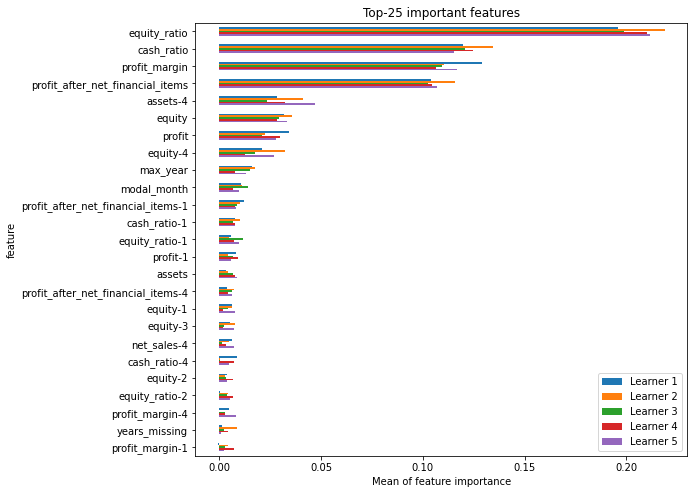

In [20]:
automl = AutoML(mode='Perform')
automl.fit(credit_df.drop('Rating',axis=1), credit_df['Rating'])


In [30]:
credit_df.loc[train_inds].to_csv('./Data/train_prc.csv')
credit_df.loc[test_inds].to_csv('./Data/test_prc.csv')

In [31]:
credit_df.isnull().sum()

revenue                                  0
revenue-1                                0
revenue-2                                0
revenue-3                                0
revenue-4                                0
net_sales                                0
net_sales-1                              0
net_sales-2                              0
net_sales-3                              0
net_sales-4                              0
profit_after_net_financial_items         0
profit_after_net_financial_items-1       0
profit_after_net_financial_items-2       0
profit_after_net_financial_items-3       0
profit_after_net_financial_items-4       0
profit                                   0
profit-1                                 0
profit-2                                 0
profit-3                                 0
profit-4                                 0
assets                                   0
assets-1                                 0
assets-2                                 0
assets-3   